In [120]:
import matplotlib.pyplot as plt
import numpy as np
import torch

%matplotlib inline

## Effect of member correctness on ensemble performance

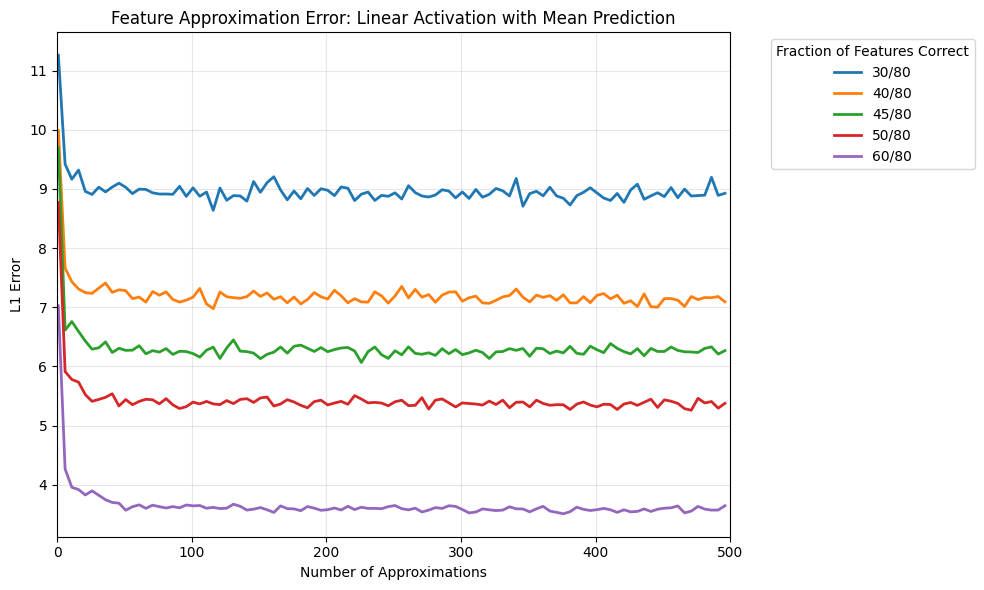

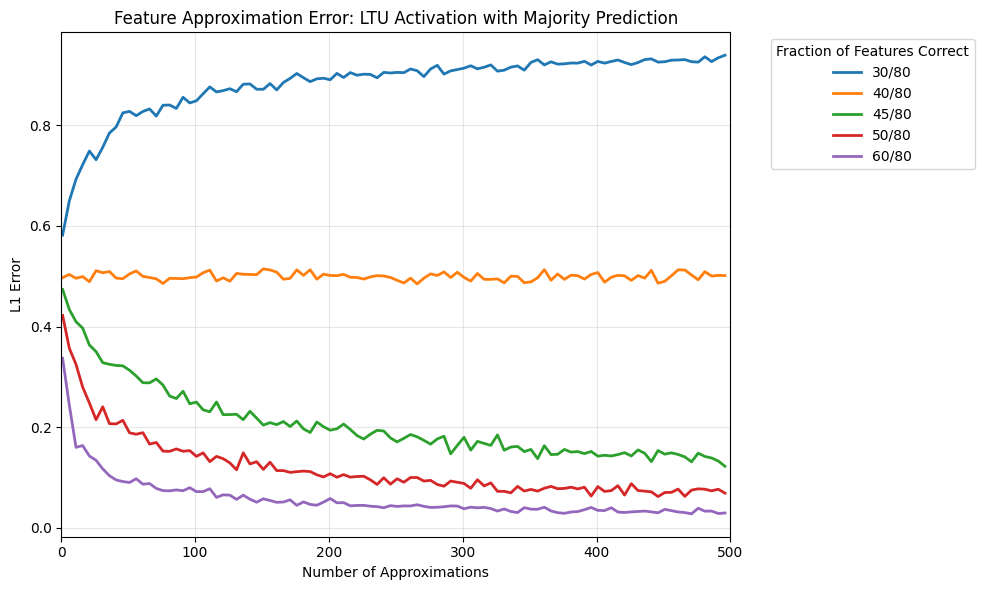

In [121]:
n_inputs = 80
n_correct_values = [30, 40, 45, 50, 60]
max_n_approximations = 500
n_approximations_list = list(range(1, max_n_approximations, 5))

target_weights = np.random.randint(0, 2, size=(n_inputs,)) * 2 - 1

ltu_activation_fn = lambda x: (x > 0).astype(float)
linear_activation_fn = lambda x: x

def run_approximation_experiment(activation_fn, prediction_type='mean', n_correct=65):
    prediction_errors_list = []
    for n_approximations in n_approximations_list:
        approx_weights = np.empty(shape=(n_approximations, n_inputs))

        for i in range(n_approximations):
            approx_weights[i, :] = target_weights[:]
            incorrect_idxs = np.random.choice(n_inputs, size=n_inputs - n_correct, replace=False)
            approx_weights[i, incorrect_idxs] = -approx_weights[i, incorrect_idxs]

        sample_inputs = np.random.randn(5000, n_inputs)

        real_outputs = activation_fn(sample_inputs @ target_weights).astype(float)
        approx_outputs = activation_fn(sample_inputs @ approx_weights.T).astype(float) # (n_samples, n_approximations)

        if prediction_type == 'mean':
            output_predictions = approx_outputs.mean(axis=1).astype(float)
        elif prediction_type == 'majority':
            output_predictions = (approx_outputs.mean(axis=1) >= 0.5).astype(float)

        prediction_errors = output_predictions - real_outputs
        l1_error = np.abs(prediction_errors).mean()
        
        prediction_errors_list.append(l1_error)
    
    return n_approximations_list, prediction_errors_list

# Run experiments for linear activation with mean prediction
linear_results_dict = {}
for n_correct in n_correct_values:
    linear_results_dict[n_correct] = run_approximation_experiment(
        linear_activation_fn, prediction_type='mean', n_correct=n_correct
    )

# Plot 1: Linear activation with mean prediction
plt.figure(figsize=(10, 6))
for n_correct in n_correct_values:
    fraction = f"{n_correct}/{n_inputs}"
    plt.plot(linear_results_dict[n_correct][0], linear_results_dict[n_correct][1], 
             label=fraction, linewidth=2)

plt.xlim(0, max_n_approximations)
plt.xlabel('Number of Approximations')
plt.ylabel('L1 Error')
plt.title('Feature Approximation Error: Linear Activation with Mean Prediction')
plt.legend(title='Fraction of Features Correct', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Run experiments for LTU activation with majority prediction
ltu_results_dict = {}
for n_correct in n_correct_values:
    ltu_results_dict[n_correct] = run_approximation_experiment(
        ltu_activation_fn, prediction_type='majority', n_correct=n_correct
    )

# Plot 2: LTU activation with majority prediction
plt.figure(figsize=(10, 6))
for n_correct in n_correct_values:
    fraction = f"{n_correct}/{n_inputs}"
    plt.plot(ltu_results_dict[n_correct][0], ltu_results_dict[n_correct][1], 
             label=fraction, linewidth=2)

plt.xlim(0, max_n_approximations)
plt.xlabel('Number of Approximations')
plt.ylabel('L1 Error')
plt.title('Feature Approximation Error: LTU Activation with Majority Prediction')
plt.legend(title='Fraction of Features Correct', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Test converting a continuous target into a cateegorical one

In [133]:
def convert_values_to_binary(tensor, integer_precision=4, decimal_precision=10):
    tensor = tensor.clone()
    total_precision = integer_precision + decimal_precision
    binary_tensor = torch.zeros((tensor.shape[0], total_precision + 1))
    
    negative_mask = tensor < 0
    binary_tensor[:, 0] = negative_mask.to(torch.float)
    
    tensor = torch.abs(tensor)
    curr_precision = 2 ** (integer_precision - 1)
    for i in range(total_precision):
        ge = tensor >= curr_precision
        binary_tensor[:, i + 1] = ge.to(torch.float)
        tensor -= ge * curr_precision
        curr_precision /= 2.0
    
        
    return binary_tensor

def convert_binary_values_to_continuous(binary_tensor, integer_precision=4, decimal_precision=10):
    total_precision = integer_precision + decimal_precision
    
    # Extract sign bit (first column)
    negative_mask = binary_tensor[:, 0] > 0.5
    
    # Extract magnitude bits (remaining columns)
    magnitude_bits = binary_tensor[:, 1:]
    
    # Convert binary to decimal
    curr_precision = 2 ** (integer_precision - 1)
    continuous_values = torch.zeros(binary_tensor.shape[0])
    
    for i in range(total_precision):
        continuous_values += magnitude_bits[:, i] * curr_precision
        curr_precision /= 2.0
    
    # Apply sign
    continuous_values = torch.where(negative_mask, -continuous_values, continuous_values)
    
    return continuous_values

# convert_values_to_binary(torch.tensor([
#   0.1, 0.25, 0.4, 0.5, 0.75, 1.0, 2.0, 3.0
# ]), integer_precision=2, decimal_precision=4)

In [134]:
n_inputs = 80
n_correct_values = [40, 50, 60]
max_n_approximations = 300
n_outputs = 15
integer_precision = 4
decimal_precision = n_outputs - integer_precision - 1
n_approximations_list = list(range(1, max_n_approximations, max_n_approximations // 50))

ltu_activation_fn = lambda x: (x > 0).to(torch.float)
linear_activation_fn = lambda x: x

target_weights = (torch.rand(n_inputs) * 2 - 1) / torch.sqrt(torch.tensor(n_inputs))
train_inputs = torch.randn(100_000, n_inputs)
train_targets = linear_activation_fn(train_inputs @ target_weights)
binary_train_targets = convert_values_to_binary(
    train_targets, integer_precision, decimal_precision)

def run_approximation_experiment(n_approximations_list, n_correct=65):
    prediction_errors_list = []

    ideal_weights = torch.zeros(n_outputs, n_inputs, requires_grad=True)

    optimizer = torch.optim.Adam([ideal_weights], lr=0.1)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Compute cross entropy loss between predictions and binary targets
    for i in range(300):
        predictions = train_inputs @ ideal_weights.T
        loss = criterion(predictions, binary_train_targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(loss.item())
    
    # n_approximations_list = [10]
    for n_approximations in n_approximations_list:
        approx_weights = torch.empty(size=(n_approximations, n_outputs, n_inputs))
        
        for i in range(n_approximations):
            approx_weights[i, :, :] = ideal_weights[:, :]
            incorrect_idxs = torch.randperm(n_inputs)[:n_inputs - n_correct]
            approx_weights[i, :, incorrect_idxs] = -approx_weights[i, :, incorrect_idxs]

        sample_inputs = torch.randn(5000, n_inputs)

        real_outputs = sample_inputs @ target_weights # activation_fn(sample_inputs @ target_weights).to(torch.float) # (n_samples)
        approx_binary_outputs = ltu_activation_fn(sample_inputs @ approx_weights.transpose(1, 2)).to(torch.float) # (n_approximations, n_samples, n_outputs)
        approx_continuous_outputs = convert_binary_values_to_continuous(
            approx_binary_outputs.reshape(-1, n_outputs), integer_precision, decimal_precision)
        approx_continuous_outputs = approx_continuous_outputs.reshape(n_approximations, sample_inputs.shape[0])

        output_predictions = (approx_continuous_outputs.mean(dim=0) >= 0.5).to(torch.float)

        prediction_errors = output_predictions - real_outputs
        l1_error = torch.abs(prediction_errors).mean()
        
        prediction_errors_list.append(l1_error)
    
    return n_approximations_list, prediction_errors_list

0.6931473612785339
0.6496323943138123
0.6488724946975708
0.6931473612785339
0.6496323943138123
0.6488724946975708
0.6931473612785339
0.6496323943138123
0.6488724946975708


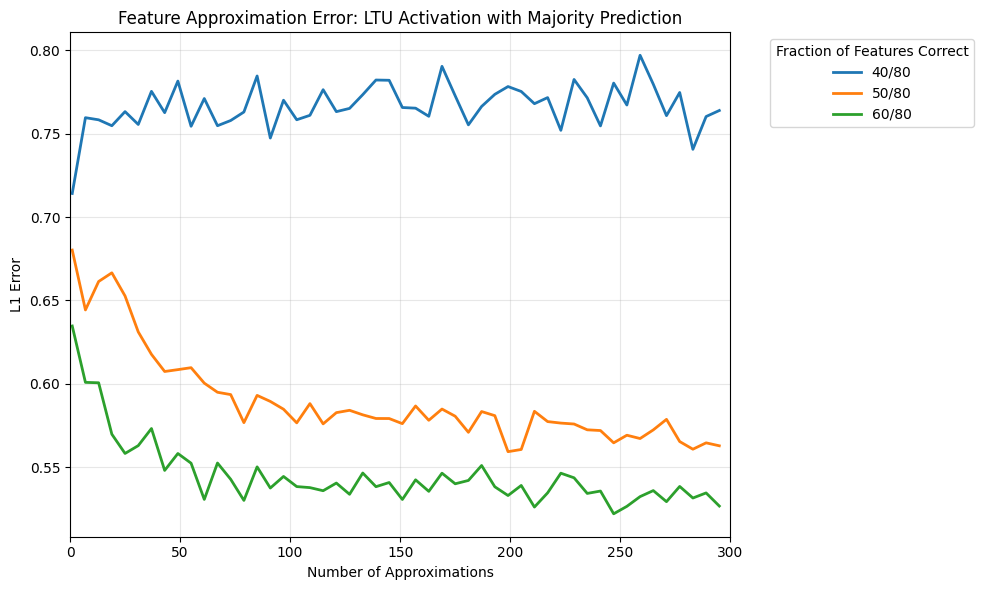

In [135]:
# Run experiments for LTU activation with majority prediction
ltu_results_dict = {}
for n_correct in n_correct_values:
    ltu_results_dict[n_correct] = run_approximation_experiment(
        n_approximations_list, n_correct=n_correct)

# Plot 2: LTU activation with majority prediction
plt.figure(figsize=(10, 6))
for n_correct in n_correct_values:
    fraction = f"{n_correct}/{n_inputs}"
    plt.plot(ltu_results_dict[n_correct][0], ltu_results_dict[n_correct][1], 
             label=fraction, linewidth=2)

plt.xlim(0, max_n_approximations)
plt.xlabel('Number of Approximations')
plt.ylabel('L1 Error')
plt.title('Feature Approximation Error: LTU Activation with Majority Prediction')
plt.legend(title='Fraction of Features Correct', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Add recurrent predictions

In [139]:
n_inputs = 80
n_correct_values = [40, 50, 60]
max_n_approximations = 300
n_outputs = 15
integer_precision = 4
decimal_precision = n_outputs - integer_precision - 1
n_approximations_list = list(range(1, max_n_approximations, max_n_approximations // 50))

ltu_activation_fn = lambda x: (x > 0).to(torch.float)
linear_activation_fn = lambda x: x


def run_approximation_experiment(n_approximations_list, n_correct=65, n_recurrent_steps=3):
    prediction_errors_list = []
    
    target_weights = (torch.rand(n_inputs) * 2 - 1) / torch.sqrt(torch.tensor(n_inputs))
    train_inputs = torch.randn(100_000, n_inputs)
    train_targets = linear_activation_fn(train_inputs @ target_weights)
    binary_train_targets = convert_values_to_binary(
        train_targets, integer_precision, decimal_precision)

    ideal_weights = torch.zeros(n_outputs, n_inputs + n_outputs, requires_grad=True)

    optimizer = torch.optim.Adam([ideal_weights], lr=0.01)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Compute cross entropy loss between predictions and binary targets
    for i in range(500):
        last_outputs = torch.zeros(100_000, n_outputs)
        optimizer.zero_grad()
        for j in range(n_recurrent_steps):
            predictions = torch.cat([last_outputs, train_inputs], dim=1) @ ideal_weights.T
            loss = criterion(predictions, binary_train_targets)
            loss.backward()
            last_outputs = predictions.detach()
        optimizer.step()
        if i % 50 == 0:
            print(loss.item())
    
    # n_approximations_list = [10]
    for n_approximations in n_approximations_list:
        approx_weights = torch.empty(size=(n_approximations, n_outputs, n_inputs + n_outputs))
        
        for i in range(n_approximations):
            approx_weights[i, :, :] = ideal_weights[:, :]
            incorrect_idxs = torch.randperm(n_inputs)[:n_inputs - n_correct] + n_outputs
            approx_weights[i, :, incorrect_idxs] = -approx_weights[i, :, incorrect_idxs]

        sample_inputs = torch.randn(5000, n_inputs) # (n_approximations, n_samples, n_inputs)

        real_outputs = sample_inputs @ target_weights # activation_fn(sample_inputs @ target_weights).to(torch.float) # (n_samples)
        
        last_outputs = torch.zeros(n_approximations, sample_inputs.shape[0], n_outputs)
        for i in range(n_recurrent_steps):
            expanded_sample_inputs = sample_inputs.expand(n_approximations, -1, -1)
            step_inputs = torch.cat([last_outputs, expanded_sample_inputs], dim=2) # (n_approximations, n_samples, n_inputs + n_outputs)
            approx_binary_outputs = ltu_activation_fn(
                step_inputs @ approx_weights.transpose(1, 2)
            ).to(torch.float) # (n_approximations, n_samples, n_outputs)
            last_outputs = approx_binary_outputs.detach()
        
        approx_continuous_outputs = convert_binary_values_to_continuous(
            approx_binary_outputs.reshape(-1, n_outputs), integer_precision, decimal_precision)
        approx_continuous_outputs = approx_continuous_outputs.reshape(n_approximations, sample_inputs.shape[0])

        output_predictions = approx_continuous_outputs.mean(dim=0) # (approx_continuous_outputs.mean(dim=0) >= 0.5).to(torch.float)

        prediction_errors = output_predictions - real_outputs
        l1_error = torch.abs(prediction_errors).mean()
        
        prediction_errors_list.append(l1_error)
    
    return n_approximations_list, prediction_errors_list

In [140]:
# run_approximation_experiment(
#     n_approximations_list, n_correct=n_correct)

### 3 Recursion Steps

0.6931473612785339
0.656586766242981
0.6517269015312195
0.6500202417373657
0.6491451263427734
0.6486065983772278
0.648247241973877
0.6479976773262024
0.6477932929992676
0.6476453542709351
0.6931473612785339
0.6561627388000488
0.6515628099441528
0.6499312520027161
0.6490883827209473
0.6485698819160461
0.6482155919075012
0.6479604840278625
0.6477696895599365
0.6476194858551025
0.6931473612785339
0.6565157771110535
0.651721715927124
0.650035560131073
0.6491735577583313
0.6486362218856812
0.6482802033424377
0.6480312347412109
0.6478326916694641
0.6477031111717224


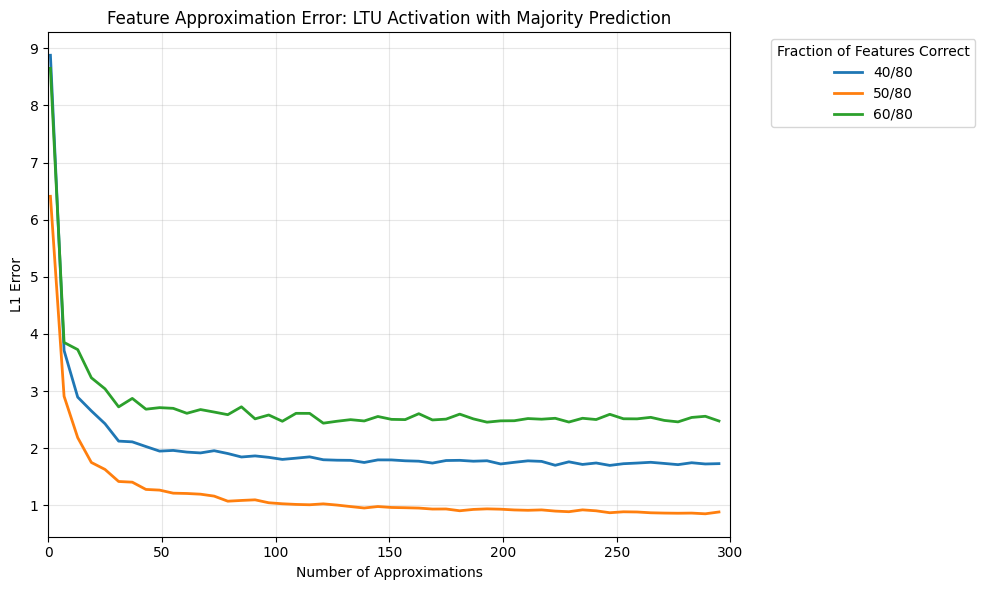

In [141]:
# Run experiments for LTU activation with majority prediction
ltu_results_dict = {}
for n_correct in n_correct_values:
    ltu_results_dict[n_correct] = run_approximation_experiment(
        n_approximations_list, n_correct=n_correct, n_recurrent_steps=3)

# Plot 2: LTU activation with majority prediction
plt.figure(figsize=(10, 6))
for n_correct in n_correct_values:
    fraction = f"{n_correct}/{n_inputs}"
    plt.plot(ltu_results_dict[n_correct][0], ltu_results_dict[n_correct][1], 
             label=fraction, linewidth=2)

plt.xlim(0, max_n_approximations)
plt.xlabel('Number of Approximations')
plt.ylabel('L1 Error')
plt.title('Feature Approximation Error: LTU Activation with Majority Prediction')
plt.legend(title='Fraction of Features Correct', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5 Recursion Steps

0.6931473612785339
0.6561393141746521
0.6504588723182678
0.6487651467323303
0.6480517983436584
0.6476191282272339
0.647407054901123
0.6472448110580444
0.6471074819564819
0.6471285223960876
0.6931473612785339
0.6557936072349548
0.6504107713699341
0.6487646698951721
0.6480182409286499
0.6476294994354248
0.6474348306655884
0.6472960114479065
0.6474587321281433
0.6470476984977722
0.6931473612785339
0.6559714078903198
0.6504256129264832
0.6487516760826111
0.6479976773262024
0.6476331353187561
0.6474559307098389
0.6472704410552979
0.6472060680389404
0.6471214294433594


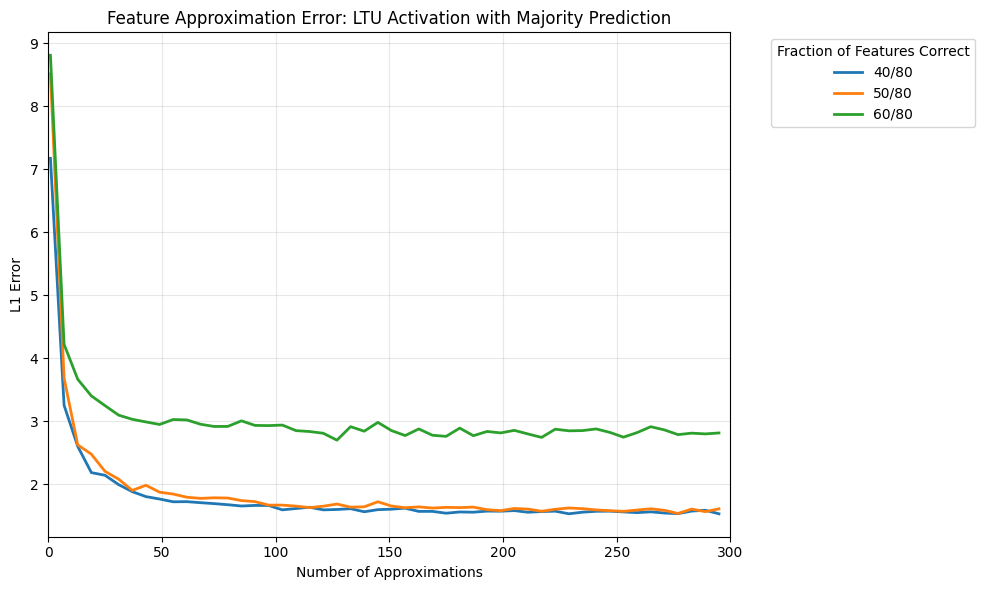

In [142]:
# Run experiments for LTU activation with majority prediction
ltu_results_dict = {}
for n_correct in n_correct_values:
    ltu_results_dict[n_correct] = run_approximation_experiment(
        n_approximations_list, n_correct=n_correct, n_recurrent_steps=5)

# Plot 2: LTU activation with majority prediction
plt.figure(figsize=(10, 6))
for n_correct in n_correct_values:
    fraction = f"{n_correct}/{n_inputs}"
    plt.plot(ltu_results_dict[n_correct][0], ltu_results_dict[n_correct][1], 
             label=fraction, linewidth=2)

plt.xlim(0, max_n_approximations)
plt.xlabel('Number of Approximations')
plt.ylabel('L1 Error')
plt.title('Feature Approximation Error: LTU Activation with Majority Prediction')
plt.legend(title='Fraction of Features Correct', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 10 recursion steps

0.6931473612785339
0.6557214856147766
0.6494402289390564
0.6477646827697754
0.6478953957557678
0.6490572094917297
0.648585855960846
0.6499688625335693
0.6703193187713623
0.6490581035614014
0.6931473612785339
0.6559728980064392
0.6495016813278198
0.6477801203727722
0.6472147703170776
0.6473422050476074
0.6476433277130127
0.654059112071991
0.6512510180473328
0.6604553461074829
0.6931473612785339
0.655866801738739
0.6494982838630676
0.64778733253479
0.6475805044174194
0.6475280523300171
0.6481072902679443
0.6490320563316345
0.6492745280265808
0.6564224362373352


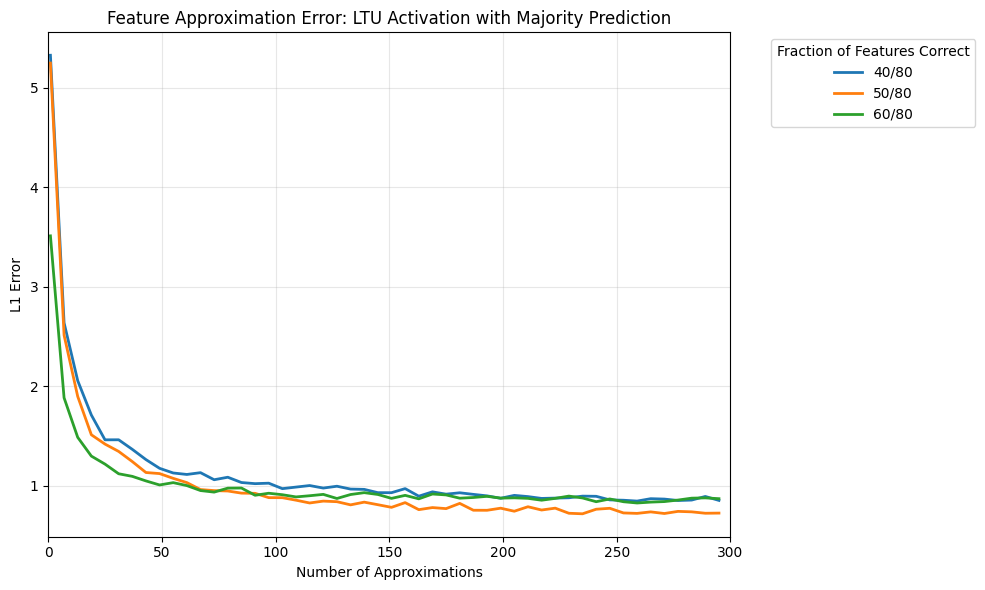

In [143]:
# Run experiments for LTU activation with majority prediction
ltu_results_dict = {}
for n_correct in n_correct_values:
    ltu_results_dict[n_correct] = run_approximation_experiment(
        n_approximations_list, n_correct=n_correct, n_recurrent_steps=10)

# Plot 2: LTU activation with majority prediction
plt.figure(figsize=(10, 6))
for n_correct in n_correct_values:
    fraction = f"{n_correct}/{n_inputs}"
    plt.plot(ltu_results_dict[n_correct][0], ltu_results_dict[n_correct][1], 
             label=fraction, linewidth=2)

plt.xlim(0, max_n_approximations)
plt.xlabel('Number of Approximations')
plt.ylabel('L1 Error')
plt.title('Feature Approximation Error: LTU Activation with Majority Prediction')
plt.legend(title='Fraction of Features Correct', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()